<p>
<img src="https://drive.google.com/uc?id=1ZHUKcwzA5c-PKUwoGmBG3TsHk6TmZ-Y0" align="left" width="250">
</p>
<p>
<h1><b><center>Mecánica Celeste</center></b></h1>
<h2><b><center>Prof. Jorge I. Zuluaga</center></b></h1>
<h2><b><center>Tarea 3</center></b><h2>
<h3><b><center>La aproximación de Apophis</center></b><h3>
<h5><center><b>Asignada</b>: 19 de Septiembre de 2023</center><h5>
<h5><center><b>Entrega</b>: 3 de Octubre de 2023</center><h5>
</p>

<hr/>
<b>Nombre</b>:
<br/>
<b>Cédula</b>:
<br/>
<b>Última actualización</b>:
<hr/>

## Enunciado

**Objetivo**: El objetivo de esta tarea es utilizar la solución analítica del problema de los dos cuerpos para estudiar la aproximación del asteroide peligroso **99942 Apophis (2004 MN4)** durante el 13 de abril del año 2029.

**Procedimiento**:

1. Obtenga el vector de estado del asteroide Apophis el día de su cumpleaños en 2023 a las 00:00:00 UTC con respecto al Sol, así como el vector de estado de la Tierra respecto al mismo sistema de referencia.

2. Determine los elementos orbitales del asteroide y los elementos órbitales osculatrices de la Tierra usando el procedimiento aprendido en clase. Estos elementos orbitales serán los que usará a partir de ahora en todos los cálculos que use la teoría del problema de los dos cuerpos. Es importante que use el procedimiento en clase en lugar de obtener simplemente los elementos de astroquery.

3. Usando los elementos orbitales de ambos cuerpos determine la mínima distancia a la que se encontarán ambas órbitas en cualquier momento del futuro. A esta distancia se la llama MOID, por el acrónimo en inglés *Minimum orbital intersection distance*.

4. Para saber cuándo se producirá la máxima aproximación entre los dos cuerpos es necesario sin embargo resolver el problema de los dos cuerpos en el tiempo. Para ello use la ecuación de Kepler y los métodos aprendidos en clase para propagar hacia el futuro la posición de la Tierra y del asteroide en el tiempo y determinar la fecha, hora y distancia de la próxima aproximación. Para ello avance primero de mes en mes por ejemplo, y luego, cerca a la aproximación máxima, de día en día, de hora en hora, hasta encontrar el punto de mínima distancia. ¿En qué fecha, hora y distancia predice usted que se producirá la máxima aproximación?

5. Una vez encontrada la fecha y hora de la aproximación obtenida con el problema exclusivamente con la solución analítica del problema de los dos cuerpos (la que estamos viendo aquí), compárela con la que se obtiene recuperando de astroquery las posiciones de la Tierra y Apophis desde su cumpleaños hacia el futuro. Es decir, repita el procedimiento anterior, pero en lugar de obtener las posiciones a partir de la teoría del problema de los dos cuerpos, recupere las posiciones usando astroquery.  ¿Qué tan diferentes son los resultados de este procedimiento y del anterior? ¿podría explicar las discrepancias?

**Resultados esperados**:

- Este notebook con el procedimiento debidamente comentado.

- Datos mínimos:
  - MOID de la órbita de Apophis y de la Tierra calculado con la teoría del problema de los 2 cuerpos.
  - Fecha, hora y distancia mínima de aproximación calculado con la teoría del problema de los 2 cuerpos.
  - Fecha, hora y distancia mínima de aproximación calculado con los datos obtenidos de Astroqery.

- Gráficos mínimos:
  - Distancia entre Apophis y la Tierra como función del tiempo desde la fecha de nacimiento hasta la máxima aproximación, calculada con la teoría del problema de los dos cuerpos y con los datos de Astroquery.

- Gráficos opcionales:
  - Animaciones de la aproximación.

- En caso de utilizar ayudas como `ChatGPT` o códigos de `Stack Over Flow` debe citar debidamente la fuente, pero también entender a cabalidad el código, el profesor puede pedir justificación.

instalemos las librerias necesarias:

In [2]:
# python3 -m pip install -q pymcel astroquery astropy plotly


Importación de librerias:

In [3]:
import pymcel as pc
import numpy as np
import pandas as pd
import spiceypy as spy
import matplotlib.pyplot as plt
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import constants as c,units as u

Constantes:

In [4]:
# Constante para convertir m^3 a km^3
m3_km3 = 10**9

# Gravitational constant en m^3/(kg s^2)
G = c.G.value

# Convertir GM a masa en Kg
GM2M = 1 / (G / m3_km3)

# Encontrar la masa del sol con alta precisión
# Descargar la librería de SPICE que contiene datos necesarios
!wget -q https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/gm_de440.tpc -O gm_de440.tpc
spy.furnsh('gm_de440.tpc')

# Obtener la información de la masa del sol desde la base de datos de SPICE
n, dato = spy.bodvrd('sun', 'GM', 1)

# Convertir unidades
M_sun = dato[0] * GM2M
M_sun=c.M_sun.value

In [5]:
M_sun=c.M_sun.value



In [6]:
# Para pasar de grados a radianes y viceversa
deg2rad = np.pi/180
rad2deg = 1/deg2rad
m3_km3= 10**9 #m^3 a km^3

# factores de conversión
day = 86400 # segundos
au = c.au.value # metros
G = c.G.value # m^3/(kg s^2)
au2km=au/1000

Unidades Canónicas:

In [7]:
UL = au # m
UM = M_sun # kg
UT = (UL**3/(G*UM))**0.5 # segundos

# Unidades derivadas
UV = UL/UT

# Entonces el mu en unidades canónicas es
mu = 1

## Solución

### 1. Obtenga el vector de estado del asteroide Apophis el día de su cumpleaños en 2023 a las 00:00:00 UTC con respecto al Sol, así como el vector de estado de la Tierra respecto al mismo sistema de referencia.

In [8]:
# Mi cumpleaños en 2023 fue el 2023-07-26
jd = Time('2023-07-26 00:00:00').jd
# Día Juliano de mi cumpleaños en 2023

# Consulta el vector de estado de Aphophis en este día
X0_aphophis_df = Horizons(
    id='2004 MN4', location='@sun', epochs=jd
).vectors().to_pandas()

# Construyendo nuestros vectores fila con el estado inicial de Aphophis
X0_aphophis = np.array(X0_aphophis_df[['x','y','z']]*au/UL)[0]  # Para la posición
X0_aphophis_norm = np.linalg.norm(X0_aphophis)  # La norma

V0_aphophis = np.array(X0_aphophis_df[['vx','vy','vz']]*(au/day)/UV)[0]  # Para la velocidad
V0_aphophis_norm = np.linalg.norm(V0_aphophis)  # La norma

# Consulta el vector de estado de la tierra en este día
X0_earth_df = Horizons(
    id='399', location='@sun', epochs=jd
).vectors().to_pandas()

# Construyendo nuestros vectores fila con el estado inicial de Aphophis
X0_earth = np.array(X0_earth_df[['x','y','z']]*au/UL)[0]  # Para la posición
X0_earth_norm = np.linalg.norm(X0_earth)  # La norma

V0_earth = np.array(X0_earth_df[['vx','vy','vz']]*(au/day)/UV)[0]  # Para la velocidad
V0_earth_norm = np.linalg.norm(V0_earth)  # La norma

### 2. Determine los elementos orbitales del asteroide y los elementos órbitales osculatrices de la Tierra usando el procedimiento aprendido en clase. Estos elementos orbitales serán los que usará a partir de ahora en todos los cálculos que use la teoría del problema de los dos cuerpos. Es importante que use el procedimiento en clase en lugar de obtener simplemente los elementos de astroquery.

### Encontremos los elementos orbitales de apophis


#### Primero calculemos los vectores clave del sistema

In [9]:
# Calculamos el M.A.R.E
hvec_aphophis = np.cross(X0_aphophis, V0_aphophis)
h_aphophis = np.linalg.norm(hvec_aphophis)

# Calculando el vector nodal
nvec_aphophis = np.cross([0, 0, 1], hvec_aphophis)  # [0, 0, 1] es el vector x unitario
n_aphophis = np.linalg.norm(nvec_aphophis)


A partir de estos vectores podemos calcular los elementos orbitales para apophis

In [10]:
# Calculando el vector de Laplace
evec_aphophis = (np.cross(V0_aphophis, hvec_aphophis) / mu -
                 X0_aphophis / X0_aphophis_norm)
e_aphophis = np.linalg.norm(evec_aphophis)  # Excentricidad

# Inclinación
I_aphophis = np.arccos(hvec_aphophis @ [0, 0, 1] / h_aphophis) * rad2deg # [0, 0, 1] es el vector z unitario

# Longitud del nodo ascendente
Omegap_aphophis = np.arccos(nvec_aphophis @ [1, 0, 0] / n_aphophis) # [1, 0, 0] es el vector x unitario
Omega_aphophis = (Omegap_aphophis if nvec_aphophis[1] >= 0 
                  else 2 * np.pi - Omegap_aphophis)
Omega_aphophis *= rad2deg

# Argumento del periapsis
omegap_aphophis = np.arccos(
    evec_aphophis @ nvec_aphophis / (e_aphophis * n_aphophis))
omega_aphophis = (omegap_aphophis if evec_aphophis[2] >= 0 
                  else 2 * np.pi - omegap_aphophis)
omega_aphophis *= rad2deg

# Anomalía verdadera
fp_aphophis = np.arccos(
    evec_aphophis @ X0_aphophis / (e_aphophis * X0_aphophis_norm))
f_aphophis = (fp_aphophis if X0_aphophis @ V0_aphophis > 0 
              else 2 * np.pi - fp_aphophis)
f_aphophis *= rad2deg

# Semilatus rectum
p_aphophis = h_aphophis**2 / mu


Creemos un dataframe con los elementos orbitales para Apophis

In [11]:
# Creando el DataFrame
data = {
    "Elementos orbitales Aphophis": [
        e_aphophis, I_aphophis, Omega_aphophis,
        omega_aphophis, f_aphophis, p_aphophis
    ]
}
indices = ["e", "I", "Omega", "omega", "f", "p"]
df = pd.DataFrame(data, index=indices)

df

,Elementos orbitales Aphophis
e,0.191443
I,3.339301
Omega,203.957180
omega,126.604463
f,109.927880
p,0.888905


### Encontremos los elementos orbitales de la tierra

#### Primero calculemos los vectores clave del sistema

In [12]:
# Calculamos el M.A.R.E
hvec_earth = np.cross(X0_earth, V0_earth)
h_earth = np.linalg.norm(hvec_earth)

# Calculando el vector nodal
nvec_earth = np.cross([0, 0, 1], hvec_earth)  # [0, 0, 1] es el vector x unitario
n_earth = np.linalg.norm(nvec_earth)


A partir de estos vectores podemos calcular los elementos orbitales para apophis

In [13]:
# Calculando el vector de Laplace
evec_earth = (np.cross(V0_earth, hvec_earth) / mu -
                 X0_earth / X0_earth_norm)
e_earth = np.linalg.norm(evec_earth)  # Excentricidad

# Inclinación
I_earth = np.arccos(hvec_earth @ [0, 0, 1] / h_earth) * rad2deg # [0, 0, 1] es el vector z unitario

# Longitud del nodo ascendente
Omegap_earth = np.arccos(nvec_earth @ [1, 0, 0] / n_earth) # [1, 0, 0] es el vector x unitario
Omega_earth = (Omegap_earth if nvec_earth[1] >= 0 
                  else 2 * np.pi - Omegap_earth)
Omega_earth *= rad2deg

# Argumento del periapsis
omegap_earth = np.arccos(
    evec_earth @ nvec_earth / (e_earth * n_earth))
omega_earth = (omegap_earth if evec_earth[2] >= 0 
                  else 2 * np.pi - omegap_earth)
omega_earth *= rad2deg

# Anomalía verdadera
fp_earth = np.arccos(
    evec_earth @ X0_earth / (e_earth * X0_earth_norm))
f_earth = (fp_earth if X0_earth @ V0_earth > 0 
              else 2 * np.pi - fp_earth)
f_earth *= rad2deg

# Semilatus rectum
p_earth = h_earth**2 / mu


Creemos un dataframe con los elementos orbitales para la tierra

In [14]:
# Creando el DataFrame
data = {
    "Elementos orbitales earth": [
        e_earth, I_earth, Omega_earth,
        omega_earth, f_earth, p_earth
    ]
}
indices = ["e", "I", "Omega", "omega", "f", "p"]
df = pd.DataFrame(data, index=indices)

df

,Elementos orbitales earth
e,0.016901
I,0.002396
Omega,217.128706
omega,244.908643
f,200.432183
p,0.999646


### 3. Usando los elementos orbitales de ambos cuerpos determine la mínima distancia a la que se encontarán ambas órbitas en cualquier momento del futuro. A esta distancia se la llama MOID, por el acrónimo en inglés *Minimum orbital intersection distance*.

### 4. Para saber cuándo se producirá la máxima aproximación entre los dos cuerpos es necesario sin embargo resolver el problema de los dos cuerpos en el tiempo. Para ello use la ecuación de Kepler y los métodos aprendidos en clase para propagar hacia el futuro la posición de la Tierra y del asteroide en el tiempo y determinar la fecha, hora y distancia de la próxima aproximación. Para ello avance primero de mes en mes por ejemplo, y luego, cerca a la aproximación máxima, de día en día, de hora en hora, hasta encontrar el punto de mínima distancia. ¿En qué fecha, hora y distancia predice usted que se producirá la máxima aproximación?

#### Para realizar este proceso, primero voy a realizar una o varias funciones que me calcule el vector de estado final, dados los elementos orbitales el tiempo inicial y final

##### Funciones auxiliares

In [15]:
def true_anomaly(jd, jdf, e, f, p, mu):
    """
    Calcula la anomalía verdadera.

    Args:
    - jd : día juliano inicial
    - jdf : ía juliano final
    - e (float): Excentricidad
    - f (float): Anomalía verdadera inicial
    - p (float): Semi-latus rectum
    - mu (float): Parámetro gravitacional

    Returns:
    float: Anomalía verdadera
    """
    # Distancia del centro de la conica al periapsis
    a = p / (1 - e**2)

    # Velocidad angular promedio
    n = (mu / abs(a**3))**0.5

    # Si f > 180°, entonces E es su complementario
    Ep = 2 * np.arctan(np.sqrt((1 - e) / (1 + e)) * np.tan(f * deg2rad / 2))
    E = Ep if f <= 180 else 2 * np.pi + Ep

    # M = E - e sin E
    M = E - e * np.sin(E)
    M = M * rad2deg

    # Condiciones finales
    Mf = M + n * (jdf - jd)
    Ef, error, niter = pc.kepler_newton(Mf * deg2rad, e, delta=1e-14)

    # Anomalía verdadera final
    ffp = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(Ef / 2))
    ff = ffp if ffp > 0 else 2 * np.pi + ffp
    return ff


def state_natural_system(p, f, e, mu, h):
    """
    Vector de estado en el sistema natural de la cónica.

    Args:
    - p (float): Semi-latus rectum
    - f (float): Anomalía verdadera inicial
    - e (float): Excentricidad
    - mu (float): Parámetro gravitacional
    - h (float): magnitud del M.A.R.E

    Returns:
    tuple: (vector de posición, vector de velocidad)
    """
    r = p / (1 + e * np.cos(f))
    xppp = r * np.cos(f)
    yppp = r * np.sin(f)
    zppp = 0
    rvec = np.array([xppp, yppp, zppp])

    vxppp = -mu / h * np.sin(f)
    vyppp = mu / h * (e + np.cos(f))
    vzppp = 0
    vvec = np.array([vxppp, vyppp, vzppp])

    return rvec, vvec


def natural2coordinate(Omega, I, w, r_vecppp, v_vecppp):
    """
    Transformación de coordenadas del sistema natural de la conica al sistema coordenado inicial.

    Args:
    - Omega (float): Longitud del nodo ascendente
    - I (float): Inclinación
    - w (float): Argumento del periapsis
    - r_vecppp (array): vector posición en el sistema natural de la conica
    - v_vecppp (array): vector velocidad en el sistema natural de la conica

    Returns:
    tuple: (vector de posición, vector de velocidad)
    """
    # Matriz de rotación inversa
    Minv = spy.eul2m(-Omega * deg2rad, -I * deg2rad, -w * deg2rad, 3, 1, 3)

    # Producto matriz vector
    rvec = spy.mxv(Minv, r_vecppp)
    vvec = spy.mxv(Minv, v_vecppp)

    # Llevandolo a au/day
    vvec = vvec * UV / (au / day)

    return rvec, vvec

#### Ya con estás funciones auxiliares podemos hacer la función que precide la posición del cuerpo dados los tiempos y los parámetros orbitales

In [16]:
def prediccion(jd, jdf, e, I, Omega, w, f, p, mu, h):
    """
    Realiza una predicción basada en los argumentos proporcionados.

    Args:
    - jd (float): día juliano inicial.
    - jdf (float): día juliano final.
    - e (float): Excentricidad.
    - I (float): Inclinación.
    - Omega (float): Longitud del nodo ascendente.
    - w (float): Argumento de periapsis.
    - f (float): Anomalía verdadera.
    - p (float): Semi-latus rectum.
    - mu (float): Parámetro gravitacional.
    - h (float): magnitud del M.A.R.E.

    Returns:
    tuple: (vector de posición (en el sistema inicial), vector de velocidad(en el sistema inicial))
    """
    # Calculamos la anomalía verdadera
    ff = true_anomaly(jd, jdf, e, f, p, mu)

    # Vector de estado en el sistema natural de la cónica
    r_vecppp, v_vecppp = state_natural_system(p, ff, e, mu, h)

    # Transformación al sistema coordenado inicial
    rvec, vvec = natural2coordinate(Omega, I, w, r_vecppp, v_vecppp)

    return rvec, vvec


#### Ya con esta función podemos ir variando el tiempo por horas, para así encontrar la posición de aphophis y la tierra en el tiempo, con esto podemos hallar el vector relativo cuya magnitud nos permite saber cual es la distancia entre la tierra y apophis en el tiempo, para finalmente hallar cual es la menor distancia entre estos cuerpos y además cuando se produce esta aproximación

In [17]:
#Definamos el intervalo de tiempo de estudio
step = 1/24 # Hora a día
increment = 365.25*10  # # años en días
t_study=np.arange(jd,jd+increment,step)

dic={'time_jd':[],'distance_earth_apophis':[]}

for jdf in t_study:

    # veamos el vector de estado para final para aphophis
    rvec_aphophis, vvec_aphophis = prediccion(jd, jdf, e_aphophis, I_aphophis, Omega_aphophis, omega_aphophis, f_aphophis, p_aphophis, mu, h_aphophis)

    # veamos el vector de estado para final para earth
    rvec_earth, vvec_earth = prediccion(jd, jdf, e_earth, I_earth, Omega_earth, omega_earth, f_earth, p_earth, mu, h_earth)
    
    # Vector relativo entre aphophis y la tierra 
    relative_vector = rvec_aphophis-rvec_earth

    # Norma del vector relativo (distancia entre los cuerpos)
    distance = np.linalg.norm(relative_vector)

    #Añadiendo la información al diccionario
    dic['time_jd'].append(jdf)
    dic['distance_earth_apophis'].append(distance)

Con lo anterior tenemos un diccionario con información en el tiempo de la distancia entre aphophis y la Tierra, entonces lo unico que queda es encontrar el minimo de distancia y en que fecha de produjo

In [18]:
#Encontremos el mínimo de distancia
min_distance=min(dic['distance_earth_apophis'])

#veamos en que día juliano se produce esta menor distancia
day_min_distance=dic['time_jd'][dic['distance_earth_apophis'].index(min_distance)]

# Ya teniendo el día juliano podemos convertirlo a formato de fecha

fecha = Time(day_min_distance, format='jd')
fecha = fecha.iso  # Representación en formato ISO (AAAA-MM-DD HH:MM:SS.sss)

/home/clickgreen/celestial_mechanics/.venv/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [19]:

# Creando el dataframe con la información
df = pd.DataFrame({
    'Mínima Distancia (Km)': [f"{min_distance*au2km:.3f}"], 
    'Fecha de Aproximación': [fecha.split('.')[0]]
})

df

,Mínima Distancia (Km),Fecha de Aproximación
0,3352200.107,2029-03-13 11:59:59


En el dataframe anterior se puede observar la minima distancia y la fecha en la que se produce esta

### 5. Una vez encontrada la fecha y hora de la aproximación obtenida con el problema exclusivamente con la solución analítica del problema de los dos cuerpos (la que estamos viendo aquí), compárela con la que se obtiene recuperando de astroquery las posiciones de la Tierra y Apophis desde su cumpleaños hacia el futuro. Es decir, repita el procedimiento anterior, pero en lugar de obtener las posiciones a partir de la teoría del problema de los dos cuerpos, recupere las posiciones usando astroquery.  ¿Qué tan diferentes son los resultados de este procedimiento y del anterior? ¿podría explicar las discrepancias?

Obtengamos la información de la posicion para aphophis y la tierra

In [20]:
data_aphophis=Horizons(
    id='2004 MN4', location='@sun',
    epochs={'start': '2023-07-06', 'stop': '2033-07-06', 'step': '1h'}
).vectors().to_pandas()

data_earth=Horizons(
    id='399', location='@sun',
    epochs={'start': '2023-07-06', 'stop': '2033-07-06', 'step': '1h'}
).vectors().to_pandas()

generemos matrices con esta información 


In [21]:
# Posiciones para apophis

rvecs_aphophis = data_aphophis[['x', 'y', 'z']].to_numpy()

rvecs_earth = data_earth[['x', 'y', 'z']].to_numpy()

#veamos la magnitud del vector relativo 

distance = list(np.linalg.norm(rvecs_aphophis - rvecs_earth, axis=1))


In [22]:
#Encontremos el mínimo de distancia
min_distance=min(distance)

#veamos en que fecha se produce esta menor distancia
day_min_distance=data_aphophis.loc[distance.index(min_distance),'datetime_str'] 

In [23]:
df = pd.DataFrame({
    'Mínima Distancia (Km)': [f"{min_distance*au2km:.3f}"], 
    'Fecha de Aproximación': [day_min_distance.split('.')[2]]
})

df

,Mínima Distancia (Km),Fecha de Aproximación
0,38410.680,2029-Apr-13 22:00:00


Ahora ya tenemos las dos fechas y hora de máxima aproximación de apophis a la tierra, y nos podemos dar de cuenta que hay un 

In [24]:
min_distance*au/1000


38410.68049612392

### Extras

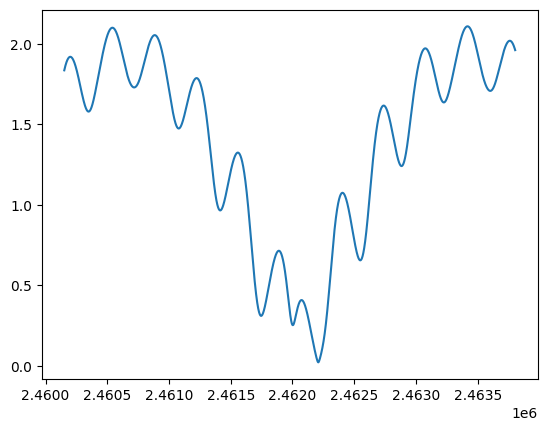

In [25]:
plt.plot(dic['time_jd'],dic['distance_earth_apophis'])

In [26]:
list(data_aphophis['datetime_str'])

['A.D. 2023-Jul-06 00:00:00.0000',
 'A.D. 2023-Jul-06 01:00:00.0000',
 'A.D. 2023-Jul-06 02:00:00.0000',
 'A.D. 2023-Jul-06 03:00:00.0000',
 'A.D. 2023-Jul-06 04:00:00.0000',
 'A.D. 2023-Jul-06 05:00:00.0000',
 'A.D. 2023-Jul-06 06:00:00.0000',
 'A.D. 2023-Jul-06 07:00:00.0000',
 'A.D. 2023-Jul-06 08:00:00.0000',
 'A.D. 2023-Jul-06 09:00:00.0000',
 'A.D. 2023-Jul-06 10:00:00.0000',
 'A.D. 2023-Jul-06 11:00:00.0000',
 'A.D. 2023-Jul-06 12:00:00.0000',
 'A.D. 2023-Jul-06 13:00:00.0000',
 'A.D. 2023-Jul-06 14:00:00.0000',
 'A.D. 2023-Jul-06 15:00:00.0000',
 'A.D. 2023-Jul-06 16:00:00.0000',
 'A.D. 2023-Jul-06 17:00:00.0000',
 'A.D. 2023-Jul-06 18:00:00.0000',
 'A.D. 2023-Jul-06 19:00:00.0000',
 'A.D. 2023-Jul-06 20:00:00.0000',
 'A.D. 2023-Jul-06 21:00:00.0000',
 'A.D. 2023-Jul-06 22:00:00.0000',
 'A.D. 2023-Jul-06 23:00:00.0000',
 'A.D. 2023-Jul-07 00:00:00.0000',
 'A.D. 2023-Jul-07 01:00:00.0000',
 'A.D. 2023-Jul-07 02:00:00.0000',
 'A.D. 2023-Jul-07 03:00:00.0000',
 'A.D. 2023-Jul-07 0

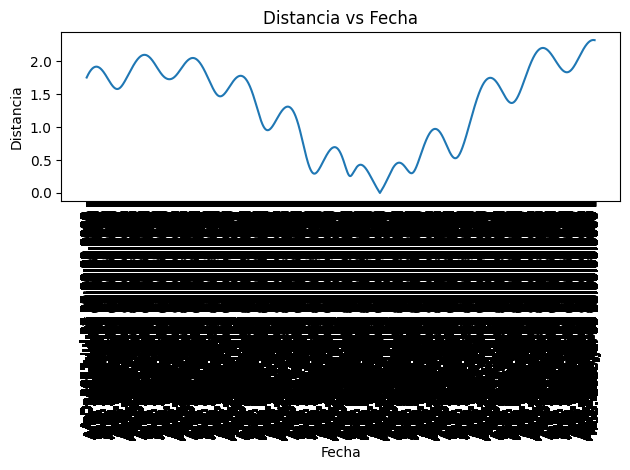

In [27]:
import matplotlib.pyplot as plt

plt.plot(list(data_aphophis['datetime_str']), distance)
plt.xlabel('Fecha')
plt.ylabel('Distancia')
plt.title('Distancia vs Fecha')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mejor visualización
plt.tight_layout()
plt.show()
